CNNs (Convolutional Neural Networks) are often said to be translation invariant, but not perfectly rotation or scale invariant by default.

Translation invariance: If an object moves slightly in the image, CNN still recognizes it.
Rotation & scale invariance: A rotated or resized version of an object might not be recognized unless the network is trained for it (e.g., via data augmentation).

In Data Augmentation , original image is converted to -> Horizontal Flip,Contrast,Zoom,Rotation : so that CNN model is trained with Rotation & scale invariant also.

In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc .  Use this link : https://www.tensorflow.org/tutorials/images/classification 

1) os (Operating System Interface)
, Purpose: Helps you interact with the operating system.
, Why used in ML / CV tasks?
   Reading/writing files and folders.
   Navigating through dataset directories (like train/, test/).
   Renaming, deleting, or checking if files exist.

2) OpenCV (cv2)
, Purpose: Open Source Computer Vision library for image/video processing.
, Why used?
   Reading and displaying images/videos.
   Converting to grayscale, resizing, cropping, thresholding.
   Detecting faces, objects, edges, contours.
   Data augmentation in deep learning.


 3) Pillow (PIL)
, Purpose: A lightweight library for basic image manipulation.
, Why used?
   Simple tasks like opening, saving, rotating, resizing images.
   Adding text, filters, and format conversions.
   Useful when you don’t need heavy processing like OpenCV.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos' , origin=dataset_url , cache_dir='.' , untar=True) # untar=True ,to unzip the zip file(.tgz)

In [3]:
data_dir

'.\\datasets\\flower_photos'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir # windows path object

WindowsPath('datasets/flower_photos')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg'))) # .glob() is a method : It’s used to search for files in a directory that match a pattern (wildcards like *, ?).
image_count

3670

In [6]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

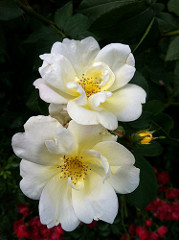

In [7]:
PIL.Image.open(str(roses[0])) # to show an image

In [8]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [9]:
flowers_images_dict['roses'][0]

WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg')

In [10]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img , img.shape #to read/load an image from disk into memory as a matrix (NumPy array). 3D-numpy array for RGB channels.

(array([[[ 0, 15,  6],
         [ 0, 15,  6],
         [ 0, 17,  8],
         ...,
         [24, 51, 31],
         [25, 52, 32],
         [26, 53, 33]],
 
        [[ 7, 22, 14],
         [ 7, 22, 14],
         [ 6, 21, 13],
         ...,
         [20, 46, 30],
         [23, 49, 33],
         [25, 51, 35]],
 
        [[12, 23, 15],
         [12, 23, 15],
         [11, 22, 14],
         ...,
         [20, 42, 30],
         [23, 45, 33],
         [26, 48, 36]],
 
        ...,
 
        [[19, 30, 27],
         [14, 24, 18],
         [12, 20, 13],
         ...,
         [ 4, 13,  3],
         [ 0,  8,  1],
         [ 0,  5,  0]],
 
        [[19, 30, 28],
         [18, 27, 24],
         [15, 23, 16],
         ...,
         [ 3, 12,  2],
         [ 1,  9,  2],
         [ 0,  7,  2]],
 
        [[ 9, 19, 19],
         [17, 25, 24],
         [22, 29, 24],
         ...,
         [ 1, 12,  2],
         [ 2, 10,  3],
         [ 3, 11,  4]]], dtype=uint8),
 (240, 179, 3))

In [11]:
cv2.resize(img,(180,180)).shape # to set the size of image to a fixed size (for all imgaes)

(180, 180, 3)

In [12]:
x,y = [],[] #to convert all images into X & Y dataset format.

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image)) # to convert libPath to normal String
        resized_img = cv2.resize(img,(180,180)) # ML model needs all images of same size
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [13]:
y[:5]

[0, 0, 0, 0, 0]

In [14]:
x = np.array(x)
y = np.array(y)

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [16]:
# Scaling our dataset : by dividing it by 255 becoz RGB channel size is (0-255)
x_train_scaled = x_train / 255 
x_test_scaled = x_test / 255
x_train_scaled.shape

(2936, 180, 180, 3)

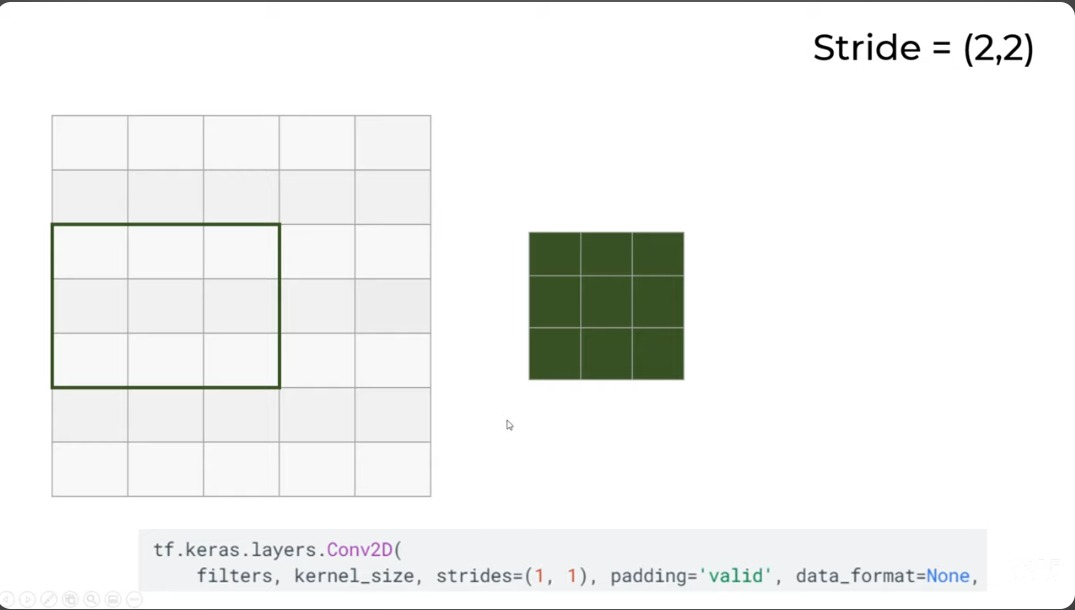
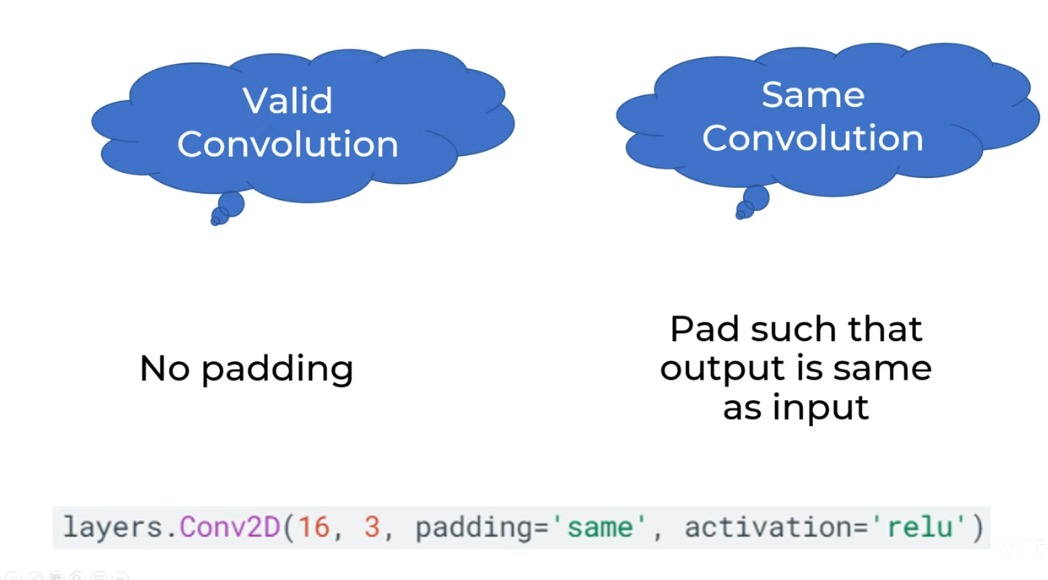

In [17]:
# We are going to build the model
model = Sequential([
  layers.Input(shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(5, activation='sigmoid')  
])
model.compile(optimizer='adam',
             loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])
              
model.fit(x_train_scaled, y_train, epochs=30) 

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 212ms/step - accuracy: 0.3535 - loss: 1.4781
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.4802 - loss: 1.2426
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.5875 - loss: 1.0334
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.6672 - loss: 0.8792
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.7119 - loss: 0.7618
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.7847 - loss: 0.5885
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.8546 - loss: 0.3915
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9223 - loss: 0.2195
Epoch 9/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.9537 - loss: 0.1353
Epoch 10/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.9775 - loss: 0.0677
Epoch 11/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.9707 - loss: 0.0884
Epoch 12/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19

In [18]:
#test accuracy is very low as compared to train data : Our model is overfitted
model.evaluate(x_test_scaled,y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6444 - loss: 3.2174  


[3.2173802852630615, 0.6444141864776611]

In [19]:
predictions = model.predict(x_test_scaled)
predictions

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step 


array([[6.8862176e-01, 8.9205348e-01, 8.8055873e-05, 1.2006566e-01,
        9.9950886e-01],
       [2.2856862e-06, 6.4910992e-06, 2.4192495e-04, 9.9999791e-01,
        1.4394602e-01],
       [8.5183060e-01, 7.1681008e-02, 2.6845797e-03, 7.2133431e-04,
        9.9711937e-01],
       ...,
       [9.7272229e-01, 9.9994999e-01, 9.3487240e-03, 6.9703132e-01,
        5.6926388e-01],
       [9.9677593e-01, 5.0081808e-02, 9.7695440e-01, 2.5058065e-07,
        4.8749712e-03],
       [2.2322291e-01, 9.3756343e-04, 7.5791901e-01, 2.3272643e-03,
        2.4492558e-02]], dtype=float32)

In [20]:
y_predicted = [np.argmax(i) for i in predictions]
y_predicted

[np.int64(4),
 np.int64(3),
 np.int64(4),
 np.int64(2),
 np.int64(4),
 np.int64(1),
 np.int64(3),
 np.int64(4),
 np.int64(4),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(4),
 np.int64(4),
 np.int64(1),
 np.int64(1),
 np.int64(4),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(0),
 np.int64(3),
 np.int64(2),
 np.int64(1),
 np.int64(4),
 np.int64(4),
 np.int64(0),
 np.int64(4),
 np.int64(4),
 np.int64(4),
 np.int64(1),
 np.int64(2),
 np.int64(1),
 np.int64(1),
 np.int64(4),
 np.int64(2),
 np.int64(3),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(4),
 np.int64(3),
 np.int64(1),
 np.int64(4),
 np.int64(3),
 np.int64(2),
 np.int64(4),
 np.int64(4),
 np.int64(3),
 np.int64(2),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(0),
 np.int64(4),
 np.int64(2),
 np.int64(3),
 np.in

In [21]:
# we will reduce the cnn model overfitting case by : Data Augemntation

# Data Augmentation Layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

model1 = Sequential([
  layers.Input(shape=(180, 180, 3)),
  data_augmentation, 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='sigmoid')  
])
model1.compile(optimizer='adam',
             loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])
              
model1.fit(x_train_scaled, y_train, epochs=30, validation_data=(x_test_scaled,y_test)) 

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - accuracy: 0.4649 - loss: 1.2295 - val_accuracy: 0.5599 - val_loss: 1.0498
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.5756 - loss: 1.0321 - val_accuracy: 0.5586 - val_loss: 1.0340
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step - accuracy: 0.6199 - loss: 0.9645 - val_accuracy: 0.6172 - val_loss: 0.9024
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.6359 - loss: 0.9275 - val_accuracy: 0.6253 - val_loss: 0.9501
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - accuracy: 0.6577 - loss: 0.8726 - val_accuracy: 0.6512 - val_loss: 0.8789
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.6778 - loss: 0.8394 - val_accuracy: 0.6689 - val_loss: 0.8410
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.6836 - loss: 0.8015 - val_accuracy: 0.7016 - val_loss: 0.7588
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.7016 - loss: 0.7758 - val_accu

In [26]:
# model has improved its acuuracy on testing data by Data Augmentation
model1.evaluate(x_test_scaled,y_test)
model1.history.history
train_accuracy = model1.history.history['accuracy']
test_accuracy = model1.history.history['val_accuracy']

train_accuracy,test_accuracy

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7480 - loss: 0.7064 


([0.46491825580596924,
  0.5756130814552307,
  0.6198909878730774,
  0.6358991861343384,
  0.6576975584030151,
  0.6777929067611694,
  0.6835830807685852,
  0.7016348838806152,
  0.6931198835372925,
  0.6989100575447083,
  0.7179836630821228,
  0.7138964533805847,
  0.7261580228805542,
  0.7370572090148926,
  0.7380790114402771,
  0.7418256402015686,
  0.7513623833656311,
  0.7554495930671692,
  0.7530654072761536,
  0.7581743597984314,
  0.7717983722686768,
  0.7656675577163696,
  0.7731607556343079,
  0.781335175037384,
  0.7799727320671082,
  0.7847411632537842,
  0.7891689538955688,
  0.8044959306716919,
  0.8048365116119385,
  0.7987056970596313],
 [0.5599455237388611,
  0.5585830807685852,
  0.6171662211418152,
  0.6253405809402466,
  0.6512261629104614,
  0.6689373254776001,
  0.7016348838806152,
  0.696185290813446,
  0.6784741282463074,
  0.6839237213134766,
  0.723433256149292,
  0.6866484880447388,
  0.7125340700149536,
  0.7070844769477844,
  0.7166212797164917,
  0.7316076